# An implementation of the credit scorecard

Based on the outcome of the WoE binining and IV information, the final step in development is the credit scorecard.

The script uses scorecardpy that can be installed from [pypi](https://pypi.org/project/scorecardpy/), and is an implementation of a R package.

In [1]:
#read in packages
import pandas as pd 
import numpy as np
from imblearn.over_sampling import SMOTENC

#read in scorecardpy
import scorecardpy as sc 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


The data preparation is straightforward.

In [16]:
data = pd.read_csv('data/after_woe.csv')
print(data.shape)
#switch to speed up the process if needed.
#data = data.sample(frac=0.01)
print(data.shape)

(230477, 39)
(230477, 39)


Set values for the scorecard.

In [17]:
dt_s=data[{'OWN', 'dti', 'other', 'bc_util', 'bc_open_to_buy',
       'mo_sin_rcnt_tl', 'moving', 'wedding', 'home_improvement',
       'tot_cur_bal', 'loan_amnt', 'mths_since_recent_bc', 'renewable_energy',
       'revol_util', 'educational', 'mort_acc', 'vacation', 'annual_inc',
       'house', 'total_rev_hi_lim', 'car', 'RENT', 'major_purchase', 'medical',
       'inq_last_6mths', 'MORTGAGE', 'small_business', 'mo_sin_rcnt_rev_tl_op',
       'NONE', 'ANY', 'credit_card', 'PERFORMING', 'revol_bal',
       'num_actv_rev_tl', 'acc_open_past_24mths', 'mo_sin_old_rev_tl_op',
       'CREDIT_HISTORY', 'avg_cur_bal'}]
#print(dt_s.shape)

(230477, 38)


Split values

In [18]:
# breaking dt into train and test
train, test = sc.split_df(dt_s, 'PERFORMING').values()
print(train.shape)
print(test.shape)

(161334, 38)
(69143, 38)


## SMOTE

Oversampling the data here using SMOTENC specifically controlling for the categorical variables. This could be included here before the filtering.

In [19]:
# filter variable via missing rate, iv, identical value rate
dt_s = sc.var_filter(dt_s, y="PERFORMING")

[INFO] filtering variables ...


/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/condition_fun.py:34: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: educational)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))


Variable filtering on 230477 rows and 37 columns in 00:06:28 
16 variables are removed


## WoE rebinning based on in ther algorithm

In [20]:
# woe binning ------
bins = sc.woebin(dt_s, y="PERFORMING")
# binning adjustment
# # adjust breaks interactively
bins_adj = sc.woebin(dt_s, y="PERFORMING")

[INFO] creating woe binning ...


/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:711: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  binning = pd.concat(bin_list, keys=bin_list.keys()).reset_index()\
/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:711: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  binning = pd.concat(bin_list, keys=bin_list.keys()).reset_index()\
/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:711: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will cha

Binning on 230477 rows and 21 columns in 00:00:29
[INFO] creating woe binning ...


/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:711: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  binning = pd.concat(bin_list, keys=bin_list.keys()).reset_index()\
/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:711: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  binning = pd.concat(bin_list, keys=bin_list.keys()).reset_index()\


Binning on 230477 rows and 21 columns in 00:00:29


In [21]:
# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)

y_train = train_woe.loc[:,'PERFORMING']
X_train = train_woe.loc[:,train_woe.columns != 'PERFORMING']
y_test = test_woe.loc[:,'PERFORMING']
X_test = test_woe.loc[:,train_woe.columns != 'PERFORMING']

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

[INFO] converting into woe values ...


/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/condition_fun.py:34: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: educational)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))


Woe transformating on 161334 rows and 20 columns in 00:00:13
[INFO] converting into woe values ...
(161334,)
(161334, 36)
(69143,)
(69143, 36)


## Logistic regression

In [27]:
# logistic regression ------
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-2, max_iter = 200)
lr.fit(X_train, y_train)
# lr.coef_
# lr.intercept_

# predicted proability
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# Performance assessment
Assess the performance of the model

/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/perf.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ], ignore_index=True)


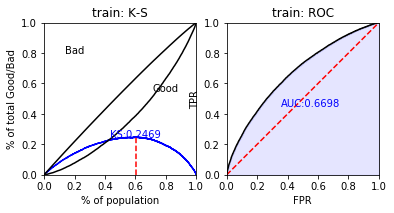

/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/perf.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  ], ignore_index=True)


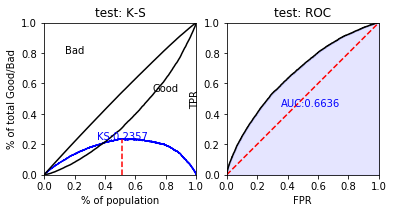

/Applications/anaconda3/lib/python3.7/site-packages/scorecardpy/condition_fun.py:34: UserWarning: There are 1 columns have only one unique values, which are removed from input dataset. 
 (ColumnNames: educational)
  warnings.warn("There are {} columns have only one unique values, which are removed from input dataset. \n (ColumnNames: {})".format(len(unique1_cols), ', '.join(unique1_cols)))
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

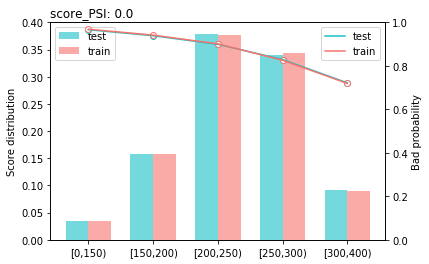

{'psi':   variable       PSI
 0    score  0.000044, 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [23]:
# performance ks & roc ------
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

# score ------
card = sc.scorecard(bins_adj, lr, X_train.columns)
# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)

# psi
sc.perf_psi(
score = {'train':train_score, 'test':test_score},
label = {'train':y_train, 'test':y_test})

The **training model** has an AUC of 0.6698 and a "Kolmogorov-Smirnov" (KS) statistic, measuring the discriminatory power of a model, has an index of 0.2469.  

KS validates the PD model, or the ability to discriminate between Performing and Non-performing customers, giving us the predictive power of the existing model. It is a point estimate and tells the score-band where the difference between cumulative good and cumulative bad customers is maximum. The ability to improve on a random classification outcome is around 25%.

The **testing model** has an AUC of 0.6636 and a "Kolmogorov-Smirnov" (KS) statistic of 0.2357. 

In [28]:
card_keys=card.keys()
card_values= card.values()

Printing the card values

In [29]:
card_values

dict_values([     variable  bin  points
0  basepoints  NaN   251.0, Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [], Empty DataFrame
Columns: [variable, bin, points]
Index: [],                 variable            bin  points
38  mo_sin_old_rev_tl_op    [-inf,50.0)     

# The scorecard
The model is baselined to 251, with the following variables, ranges, and scores.


| Variables  	            | Range         	    | Score     |
|:-----------------------	|:---------------------:|---------:	|
| `mo_sin_old_rev_tl_op`  	| {-inf,50.0}         	| 7.0     	|
| mo_sin_old_rev_tl_op  	| {50.0,140.0}        	| 3.0     	|
| mo_sin_old_rev_tl_op  	| {140.0,190.0}       	| -1.0    	|
| mo_sin_old_rev_tl_op  	| {190.0,inf}         	| -4.0    	|
| `num_actv_rev_tl`       	| {-inf,3.0}          	| -6.0    	|
| num_actv_rev_tl       	| {3.0,5.0}           	| -3.0    	|
| num_actv_rev_tl       	| {5.0,8.0}           	| 1.0     	|
| num_actv_rev_tl       	| {8.0,inf}           	| 5.0     	|
| `bc_open_to_buy`        	| missing             	| -3.0    	|
| bc_open_to_buy        	| {-inf,1000.0}       	| 13.0    	|
| bc_open_to_buy        	| {1000.0,6000.0}     	| 7.0     	|
| bc_open_to_buy        	| {6000.0,12000.0}    	| -3.0    	|
| bc_open_to_buy        	| {12000.0,29000.0}   	| -13.0   	|
| bc_open_to_buy        	| {29000.0,inf}       	| -31.0   	|
| `inq_last_6mths `       	| {-inf,1.0}          	| -10.0   	|
| inq_last_6mths        	| {1.0,2.0}           	| 8.0     	|
| inq_last_6mths        	| {2.0,inf}           	| 23.0    	|
| `bc_util `              	| missing             	| -2.0    	|
| bc_util               	| {-inf,35.0}         	| -9.0    	|
| bc_util               	| {35.0,50.0}         	| -4.0    	|
| bc_util               	| {50.0,90.0}         	| 2.0     	|
| bc_util               	| {90.0,inf}          	| 9.0     	|
| `mort_acc `             	| {-inf,1.0}          	| 2.0     	|
| mort_acc              	| {1.0,2.0}           	| -0.0    	|
| mort_acc              	| {2.0,4.0}           	| -2.0    	|
| mort_acc              	| {4.0,inf}           	| -3.0    	|
| `mo_sin_rcnt_rev_tl_op` 	| {-inf,4.0}          	| -2.0    	|
| mo_sin_rcnt_rev_tl_op 	| {4.0,17.0}          	| -0.0    	|
| mo_sin_rcnt_rev_tl_op 	| {17.0,26.0}         	| 2.0     	|
| mo_sin_rcnt_rev_tl_op 	| {26.0,inf}          	| 5.0     	|
| `avg_cur_bal`           	| {-inf,8000.0}       	| 5.0     	|
| avg_cur_bal           	| {8000.0,16000.0}    	| -1.0    	|
| avg_cur_bal           	| {16000.0,23000.0}   	| -6.0    	|
| avg_cur_bal           	| {23000.0,35000.0}   	| -10.0   	|
| avg_cur_bal           	| {35000.0,inf}       	| -17.0   	|
| `tot_cur_bal`           	| {-inf,20000.0}      	| 1.0     	|
| tot_cur_bal           	| {20000.0,100000.0}  	| 4.0     	|
| tot_cur_bal           	| {100000.0,200000.0} 	| -1.0    	|
| tot_cur_bal           	| {200000.0,360000.0} 	| -5.0    	|
| tot_cur_bal           	| {360000.0,inf}      	| -10.0   	|
| `mo_sin_rcnt_tl`        	| {-inf,4.0}          	| 5.0     	|
| mo_sin_rcnt_tl        	| {4.0,7.0}           	| 1.0     	|
| mo_sin_rcnt_tl        	| {7.0,10.0}          	| -1.0    	|
| mo_sin_rcnt_tl        	| {10.0,18.0}         	| -5.0    	|
| mo_sin_rcnt_tl        	| {18.0,inf}          	| -12.0   	|
| `dti`                   	| missing             	| -28.0   	|
| dti                   	| {-inf,12.0}         	| -11.0   	|
| dti                   	| {12.0,18.0}         	| -5.0    	|
| dti                   	| {18.0,24.0}         	| 2.0     	|
| dti                   	| {24.0,inf}          	| 11.0    	|
| `annual_inc`            	| {-inf,60000.0}      	| 6.0     	|
| annual_inc            	| {60000.0,80000.0}   	| 1.0     	|
| annual_inc            	| {80000.0,115000.0}  	| -5.0    	|
| annual_inc            	| {115000.0,inf}      	| -15.0   	|
| `acc_open_past_24mths ` 	| {-inf,3.0}          	| -24.0   	|
| acc_open_past_24mths  	| {3.0,4.0}           	| -9.0    	|
| acc_open_past_24mths  	| {4.0,8.0}           	| 7.0     	|
| acc_open_past_24mths  	| {8.0,inf}           	| 25.0    	|
| `revol_bal `            	| {-inf,2000.0}       	| 1.0     	|
| revol_bal             	| {2000.0,22000.0}    	| -3.0    	|
| revol_bal             	| {22000.0,42000.0}   	| 4.0     	|
| revol_bal             	| {42000.0,inf}       	| 21.0    	|
| revol_util            	| missing             	| 10.0    	|
| revol_util            	| {-inf,22.0}         	| -7.0    	|
| revol_util            	| {22.0,40.0}         	| -3.0    	|
| revol_util            	| {40.0,54.0}         	| 0.0     	|
| revol_util            	| {54.0,inf}          	| 3.0     	|
| `loan_amnt `            	| {-inf,6000.0}       	| -30.0   	|
| loan_amnt             	| {6000.0,11000.0}    	| -11.0   	|
| loan_amnt             	| {11000.0,25000.0}   	| 14.0    	|
| loan_amnt             	| {25000.0,inf}       	| 2.0     	|
|` total_rev_hi_lim `     	| {-inf,16000.0}      	| 12.0    	|
| total_rev_hi_lim      	| {16000.0,26000.0}   	| 6.0     	|
| total_rev_hi_lim      	| {26000.0,50000.0}   	| -3.0    	|
| total_rev_hi_lim      	| {50000.0,82000.0}   	| -19.0   	|
| total_rev_hi_lim      	| {82000.0,inf}       	| -41.0   	|
| `mths_since_recent_bc ` 	| missing             	| -4.0    	|
| mths_since_recent_bc  	| {-inf,4.0}          	| 9.0     	|
| mths_since_recent_bc  	| {4.0,12.0}          	| 4.0     	|
| mths_since_recent_bc  	| {12.0,20.0}         	| 1.0     	|
| mths_since_recent_bc  	| {20.0,36.0}         	| -4.0    	|
| mths_since_recent_bc  	| {36.0,inf}          	| -11.0]} 	|

In [15]:
bins_adj

{'CREDIT_HISTORY':          variable          bin  count  count_distr  good  bad   badprob  \
 0  CREDIT_HISTORY  [-inf,14.0)    955     0.414317   127  828  0.867016   
 1  CREDIT_HISTORY  [14.0,15.0)    169     0.073319    20  149  0.881657   
 2  CREDIT_HISTORY  [15.0,16.0)    142     0.061605    10  132  0.929577   
 3  CREDIT_HISTORY  [16.0,17.0)    131     0.056833    22  109  0.832061   
 4  CREDIT_HISTORY  [17.0,19.0)    195     0.084599    19  176  0.902564   
 5  CREDIT_HISTORY  [19.0,26.0)    423     0.183514    60  363  0.858156   
 6  CREDIT_HISTORY  [26.0,30.0)    133     0.057701    27  106  0.796992   
 7  CREDIT_HISTORY   [30.0,inf)    157     0.068113    19  138  0.878981   
 
         woe    bin_iv  total_iv breaks  is_special_values  
 0 -0.009549  0.000038  0.058411   14.0              False  
 1  0.123839  0.001074  0.058411   15.0              False  
 2  0.695842  0.023013  0.058411   16.0              False  
 3 -0.284069  0.005084  0.058411   17.0             

In [ ]:
# ENDS # ENDS # ENDS
#########################################################################################
# ENDS ####### (c) Peter Went, 2019
#########################################################################################